## Merge movil y fijo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (5, 2)
plt.rcParams['figure.dpi'] = 140

from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer, StandardScaler
import time
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import datasets

Leemos los datos ya consolidados:

In [2]:
df1 = pd.read_csv('fijo_consolidado.txt', sep='\t')
df2 = pd.read_csv('base_completa_movil.csv', encoding='latin-1')

Unificamos los nombres de Columnas

In [3]:
df2 = df2[['encriptado', 'periodo', 'segmento', 'total', 'n_recl_com', 'n_recl_tec', 'n_churn', 'nota_sem']]
df1 = df1[['encriptado', 'MES', 'SEGMENTO', 'MONTO', 'RECLAMO_COM', 'RECLAMO_TEC', 'CHURN']]
df1.columns = ['encriptado', 'periodo', 'segmento', 'total', 'n_recl_com', 'n_recl_tec', 'n_churn']

Cambiamos la escala de tiempo:

In [4]:
df1.loc[df1['periodo'] <= 6, 'periodo2'] = '2019_q1'
df1.loc[(df1['periodo'] > 6) & (df1['periodo'] <= 12), 'periodo2'] = '2019_q2'
df1.loc[(df1['periodo'] > 12) & (df1['periodo'] <= 18), 'periodo2'] = '2020_q1'
df1.loc[(df1['periodo'] > 18) & (df1['periodo'] <= 24), 'periodo2'] = '2020_q2'

df1.drop('periodo', axis=1, inplace=True)
df1.rename(columns = {'periodo2': 'periodo'}, inplace=True)

Agrupamos la base de productos fijos:

In [5]:
df1 = df1.groupby(by=['encriptado', 'segmento', 'periodo'],
                  as_index=False).agg({'total': np.mean,
                                       'n_recl_com': np.sum,
                                       'n_recl_tec': np.sum,
                                       'n_churn': np.sum})

In [6]:
df2 = df2.groupby(by=['encriptado', 'segmento', 'periodo'],
                  as_index=False).agg({'total': np.mean,
                                       'n_recl_com': np.sum,
                                       'n_recl_tec': np.sum,
                                       'n_churn': np.sum})

Unificamos:

In [7]:
df1.loc[:, 'tipo'] = 'Fijo'
df2.loc[:, 'tipo'] = 'Movil'
df = pd.concat([df1, df2], axis=0)

In [8]:
l1 = ['MICRO Y SOHO', 'MEDIANAS', 'S/I', 'EMPRESAS', 'GRANDES CUENTAS',
      'PEQUENAS', 'GRANDES CLIENTES', 'empresas']
l2 = ['masivos', 'mmee', 's/i', 'ggee', 'ggee', 'masivos', 'ggee', 'ggee']

df.loc[:, 'segmento'] = df['segmento'].replace(l1, l2)

df3 = df.groupby(by=['encriptado', 'segmento', 'periodo', 'tipo'], as_index=False).sum()

Filtramos:

In [9]:
df3 = df3.loc[(df3['total'] >= 1000) & (df3['total'] <= 10000000), :]
df3 = df3.loc[df3['n_recl_com'] <= 10, :]
df3 = df3.loc[df3['n_recl_tec'] <= 10, :]

df3.loc[:, 'log_total'] = np.log(df3['total'])
df3.loc[:, 'churn'] = 0
df3.loc[df3['n_churn']>0, 'churn'] = 1

In [10]:
df3.sort_values(by=['encriptado', 'segmento', 'tipo', 'periodo'], inplace=True)
df3.reset_index(drop=True, inplace=True)

In [11]:
df3['n_recl_com_cumsum'] = df3.groupby(['encriptado', 'segmento', 'tipo'])['n_recl_com'].transform(pd.Series.cumsum)
df3['n_recl_tec_cumsum'] = df3.groupby(['encriptado', 'segmento', 'tipo'])['n_recl_tec'].transform(pd.Series.cumsum)

## Gráficos

([<matplotlib.axis.XTick at 0x2737932cf70>,
 [Text(0, 0, 'Sin info.'),
  Text(0, 0, 'Masivos'),
  Text(0, 0, 'Medianas'),
  Text(0, 0, 'Grandes')])

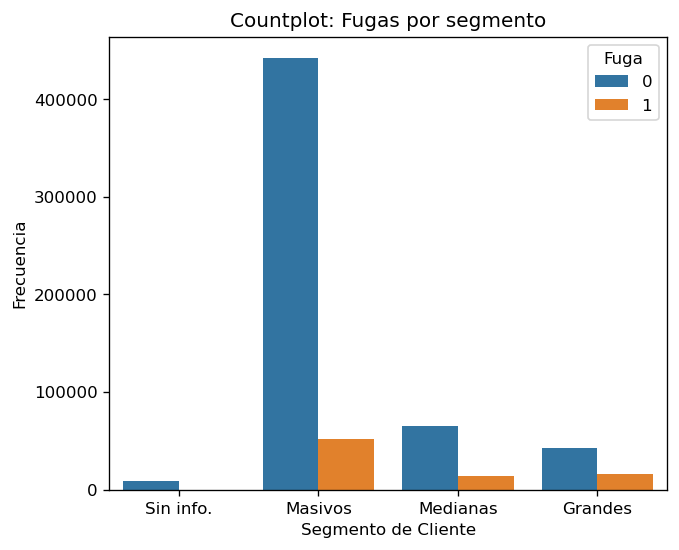

In [14]:
plt.figure(figsize=(6, 5), dpi=120)
sns.countplot(x="segmento", hue="churn", data=df3, order=rank)
plt.xlabel('Segmento de Cliente')
plt.ylabel('Frecuencia')
plt.title('Countplot: Fugas por segmento')
plt.legend(title='Fuga')
plt.xticks(ticks = range(0,4),
           labels=['Sin info.', 'Masivos', 'Medianas' , 'Grandes'])

([<matplotlib.axis.XTick at 0x1e4586ef910>,
 [Text(0, 0, '2019-1'),
  Text(0, 0, '2019-2'),
  Text(0, 0, '2020-1'),
  Text(0, 0, '2020-2')])

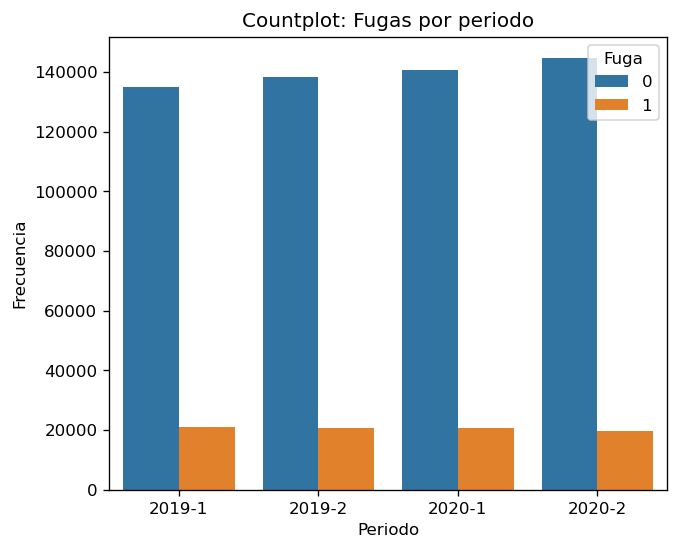

In [50]:
plt.figure(figsize=(6, 5), dpi=120)
sns.countplot(x="periodo", hue="churn", data=df3,
             order=['2019_q1', '2019_q2', '2020_q1', '2020_q2'])
plt.xlabel('Periodo')
plt.ylabel('Frecuencia')
plt.title('Countplot: Fugas por periodo')
plt.legend(title='Fuga')
plt.xticks(ticks = range(0,4),
           labels=['2019-1', '2019-2', '2020-1', '2020-2'])

In [42]:
df3.periodo.unique()

array(['2020_q1', '2020_q2', '2019_q1', '2019_q2'], dtype=object)

([<matplotlib.axis.XTick at 0x1e458bc23a0>,
 [Text(0, 0, 'Sin info.'),
  Text(0, 0, 'Masivos'),
  Text(0, 0, 'Medianas'),
  Text(0, 0, 'Grandes')])

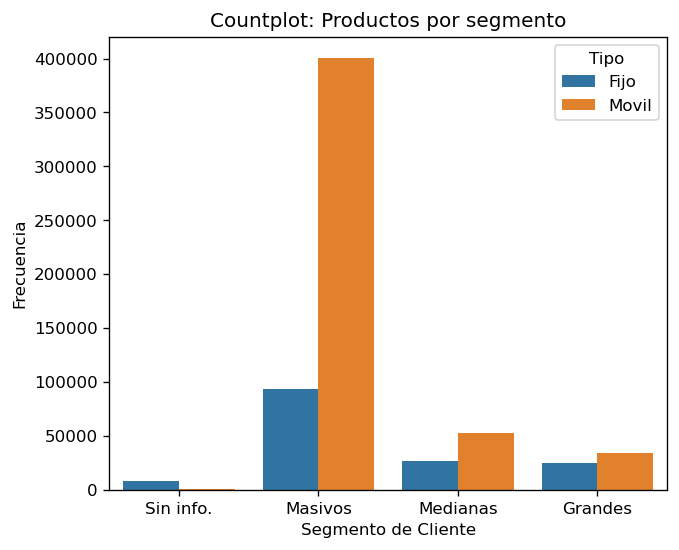

In [30]:
plt.figure(figsize=(6, 5), dpi=120)
sns.countplot(x="segmento", hue="tipo", data=df3, order=rank)
plt.xlabel('Segmento de Cliente')
plt.ylabel('Frecuencia')
plt.title('Countplot: Productos por segmento')
plt.legend(title='Tipo')
plt.xticks(ticks = range(0,4),
           labels=['Sin info.', 'Masivos', 'Medianas' , 'Grandes'])

In [25]:
rank

['s/i', 'masivos', 'mmee', 'ggee']

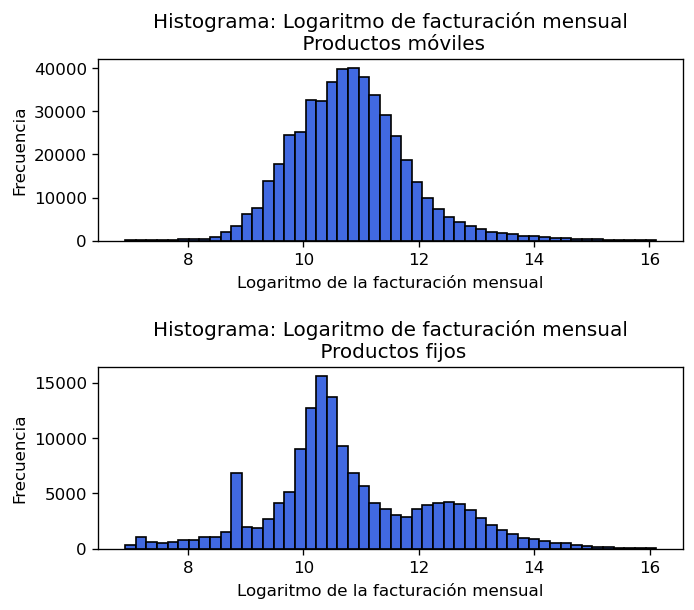

In [31]:
plt.figure(figsize=(6, 5), dpi=120)

plt.subplot(2,1,1)
plt.tight_layout()

plt.hist(data= df3[df3['tipo'] == 'Movil'], x = 'log_total',
         bins=50, histtype='bar', ec='black', facecolor = 'royalblue')
plt.xlabel("Logaritmo de la facturación mensual")
plt.ylabel("Frecuencia")
plt.title("Histograma: Logaritmo de facturación mensual\n Productos móviles")

plt.subplot(2,1,2)
plt.tight_layout()
plt.hist(data= df3[df3['tipo'] == 'Fijo'], x = 'log_total',
         bins=50, histtype='bar', ec='black', facecolor = 'royalblue')
plt.xlabel("Logaritmo de la facturación mensual")
plt.ylabel("Frecuencia")
plt.title("Histograma: Logaritmo de facturación mensual\n Productos fijos")
plt.subplots_adjust(hspace=0.7)

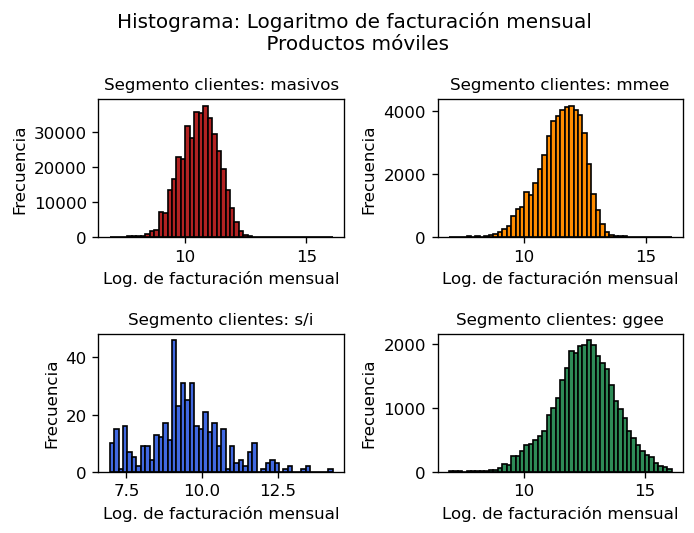

In [13]:
plt.figure(figsize=(6, 4), dpi=120)
colores = ['firebrick', 'darkorange', 'royalblue', 'seagreen']
for i, row_n in enumerate(df['segmento'].unique()):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.hist(data= df3[(df3['tipo'] == 'Movil') & (df3['segmento'] == row_n)],
           x = 'log_total', bins=50, histtype='bar', ec='black',
           facecolor=colores[i])
    plt.xlabel("Log. de facturación mensual", fontsize=10)
    plt.ylabel("Frecuencia", fontsize=10)
    plt.title("Segmento clientes: "+row_n, fontsize=10)
plt.suptitle("Histograma: Logaritmo de facturación mensual\n Productos móviles",
            y=1.1)
plt.subplots_adjust(hspace=0.7)

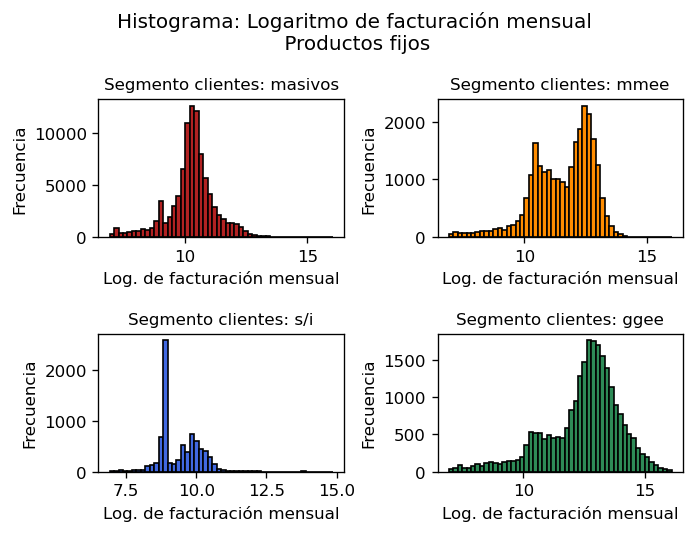

In [14]:
plt.figure(figsize=(6, 4), dpi=120)
colores = ['firebrick', 'darkorange', 'royalblue', 'seagreen']
for i, row_n in enumerate(df['segmento'].unique()):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.hist(data= df3[(df3['tipo'] == 'Fijo') & (df3['segmento'] == row_n)],
           x = 'log_total', bins=50, histtype='bar', ec='black',
           facecolor=colores[i])
    plt.xlabel("Log. de facturación mensual", fontsize=10)
    plt.ylabel("Frecuencia", fontsize=10)
    plt.title("Segmento clientes: "+row_n, fontsize=10)
plt.suptitle("Histograma: Logaritmo de facturación mensual\n Productos fijos",
            y=1.1)
plt.subplots_adjust(hspace=0.7)

In [13]:
rank = ['s/i', 'masivos', 'mmee', 'ggee']

Text(0.5, 1.0, 'Gráfico de densidades del logaritmo\ndel total de productos fijos\npor segmento y por churn')

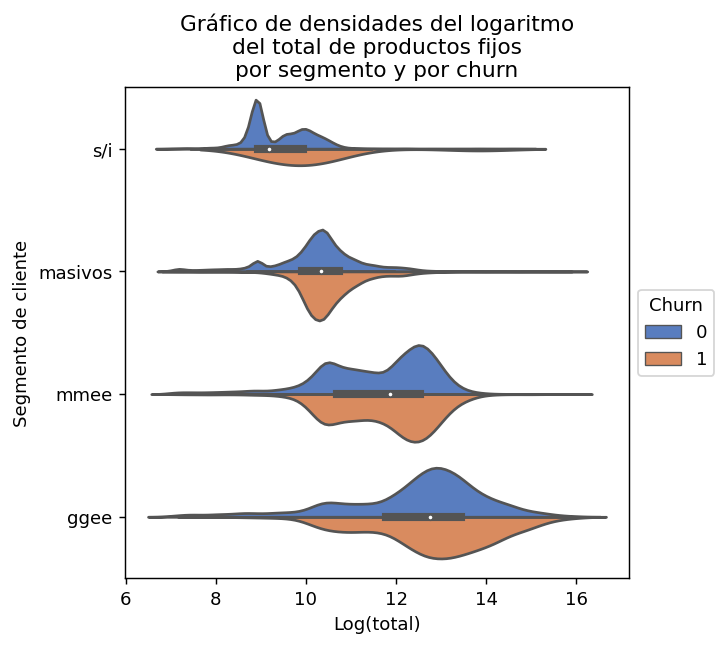

In [32]:
plt.figure(figsize=(5, 5), dpi=130)
sns.violinplot(y="segmento", x="log_total", hue="churn",
               data=df3[df3['tipo']=='Fijo'], palette="muted", split=True, 
               order=rank)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           ncol=1, title = 'Churn')
plt.ylabel('Segmento de cliente')
plt.xlabel('Log(total)')
plt.title('Gráfico de densidades del logaritmo\ndel total de productos fijos\npor segmento y por churn')

In [17]:
for seg in df3['segmento'].unique():
    tdf = df3[(df3['segmento'] == seg) & (df3['churn'] == 1)]
    print('Segmento:', seg)
    print('   La media es:', tdf['log_total'].mean())
    print('   La std es:', tdf['log_total'].std())

for seg in df3['segmento'].unique():
    tdf = df3[(df3['segmento'] == seg) & (df3['churn'] == 0)]
    print('Segmento:', seg)
    print('   La media es:', tdf['log_total'].mean())
    print('   La std es:', tdf['log_total'].std())

Segmento: masivos
   La media es: 10.651371111206341
   La std es: 0.8141005987542322
Segmento: mmee
   La media es: 11.746495120132652
   La std es: 0.8985985879961899
Segmento: s/i
   La media es: 10.149344976009079
   La std es: 1.2233691310509143
Segmento: ggee
   La media es: 13.001752134785328
   La std es: 1.2567268654789343
Segmento: masivos
   La media es: 10.502210318993315
   La std es: 0.8265159889104433
Segmento: mmee
   La media es: 11.490688570703039
   La std es: 1.0586816378948671
Segmento: s/i
   La media es: 9.405404667309707
   La std es: 0.7661053622421183
Segmento: ggee
   La media es: 12.31268336674126
   La std es: 1.40065968480778


Text(0.5, 1.0, 'Gráfico de densidades del logaritmo\ndel total de productos móviles\npor segmento y por churn')

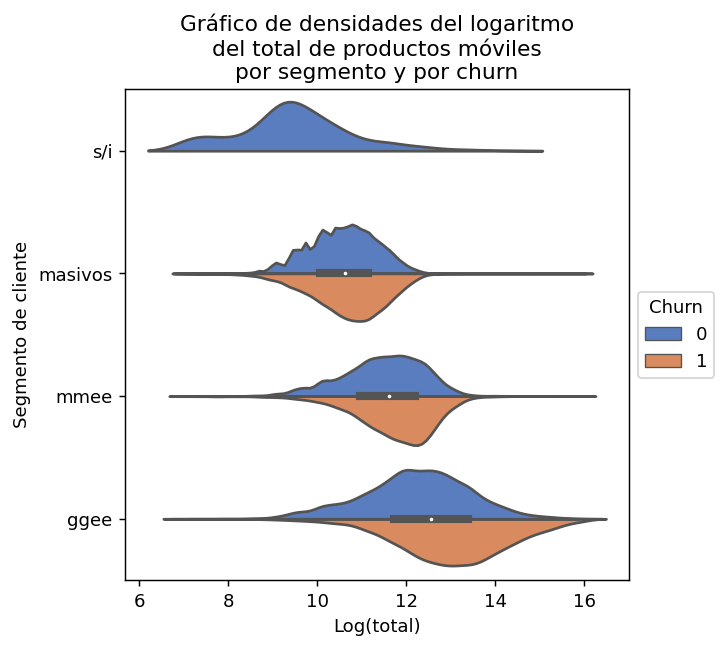

In [51]:
plt.figure(figsize=(5, 5), dpi=130)
sns.violinplot(y="segmento", x="log_total", hue="churn",
               data=df3[df3['tipo']=='Movil'], palette="muted", split=True, 
               order=rank)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           ncol=1, title = 'Churn')
plt.ylabel('Segmento de cliente')
plt.xlabel('Log(total)')
plt.title('Gráfico de densidades del logaritmo\ndel total de productos móviles\npor segmento y por churn')

In [19]:
'''sns.catplot(x="segmento", y="log_total", hue='churn',
            row = 'tipo',  order=rank, kind="violin", split=True,
            data=df3, palette="muted", height=4)
plt.ylabel("Log. de factuación mensual")'''

'sns.catplot(x="segmento", y="log_total", hue=\'churn\',\n            row = \'tipo\',  order=rank, kind="violin", split=True,\n            data=df3, palette="muted", height=4)\nplt.ylabel("Log. de factuación mensual")'

In [20]:
'''sns.catplot(x="churn", col="segmento", col_wrap=4,
            data = df3,
            kind="count",
            height=2.5, aspect=.8)'''

'sns.catplot(x="churn", col="segmento", col_wrap=4,\n            data = df3,\n            kind="count",\n            height=2.5, aspect=.8)'

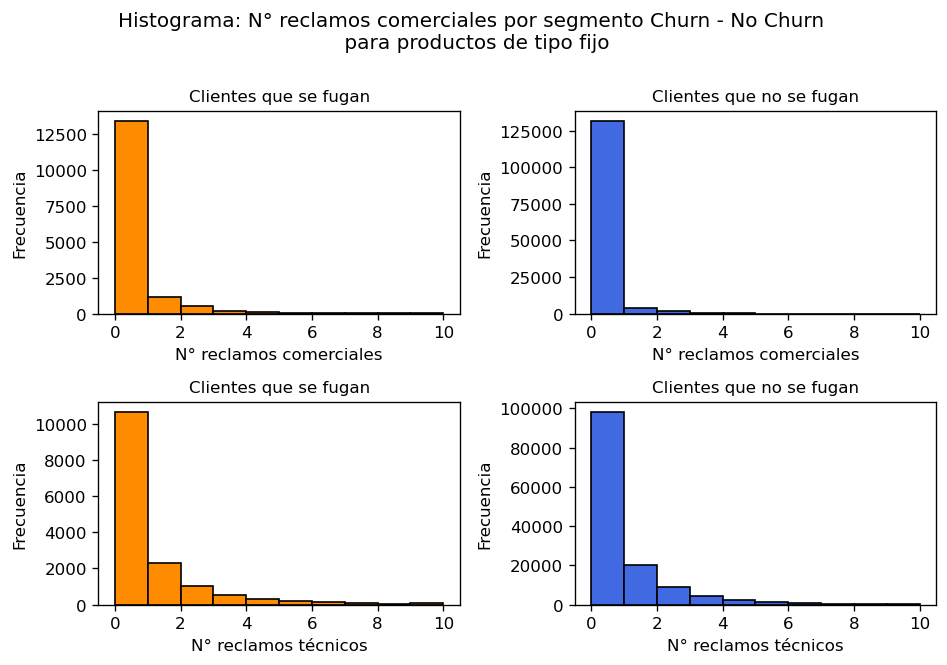

In [55]:
plt.figure(figsize=(8, 5), dpi=120)
colores = ['firebrick', 'darkorange', 'royalblue', 'seagreen']
plt.subplot(2,2,1)
plt.tight_layout()

plt.hist(data = df3[(df3['tipo'] == 'Fijo') & (df3['churn']==1)],
         x = 'n_recl_com', rwidth=1, histtype='bar', ec='black',
         facecolor=colores[1])
plt.xlabel("N° reclamos comerciales", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)

plt.title("Clientes que se fugan", fontsize=10)

plt.subplot(2,2,2)
plt.tight_layout()

plt.hist(data = df3[(df3['tipo'] == 'Fijo') & (df3['churn']==0)],
         x = 'n_recl_com', rwidth=1, histtype='bar', ec='black',
         facecolor=colores[2])
plt.xlabel("N° reclamos comerciales", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)

plt.title("Clientes que no se fugan", fontsize=10)

plt.suptitle("Histograma: N° reclamos comerciales por segmento Churn - No Churn \n para productos de tipo fijo",
            y=1.1)
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()


plt.subplot(2,2,3)
plt.tight_layout()

plt.hist(data = df3[(df3['tipo'] == 'Fijo') & (df3['churn']==1)],
         x = 'n_recl_tec', rwidth=1, histtype='bar', ec='black',
         facecolor=colores[1])
plt.xlabel("N° reclamos técnicos", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)

plt.title("Clientes que se fugan", fontsize=10)

plt.subplot(2,2,4)
plt.tight_layout()

plt.hist(data = df3[(df3['tipo'] == 'Fijo') & (df3['churn']==0)],
         x = 'n_recl_tec', rwidth=1, histtype='bar', ec='black',
         facecolor=colores[2])
plt.xlabel("N° reclamos técnicos", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)

plt.title("Clientes que no se fugan", fontsize=10)

plt.tight_layout()

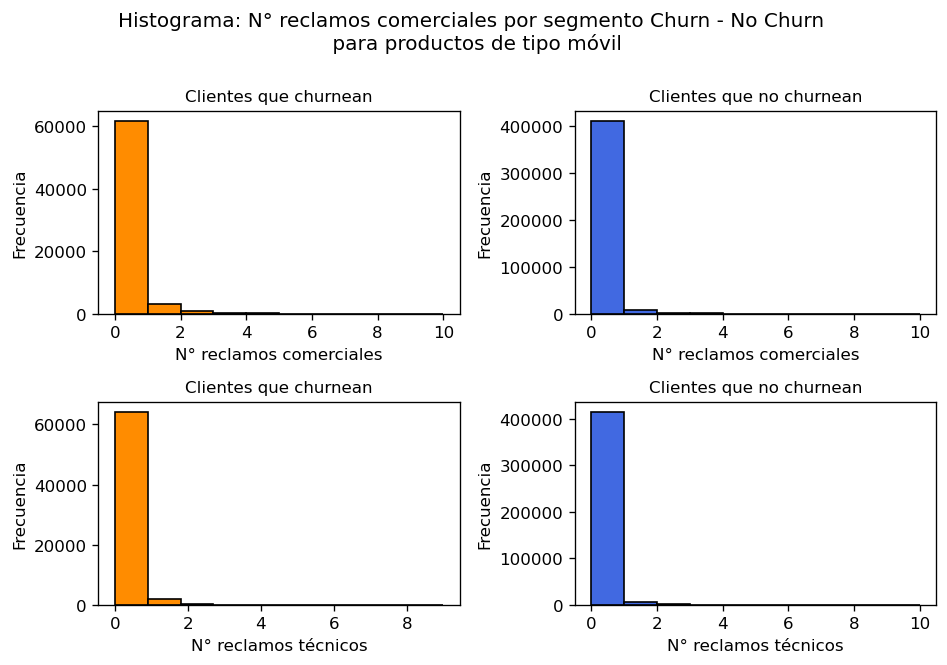

In [56]:
plt.figure(figsize=(8, 5), dpi=120)
colores = ['firebrick', 'darkorange', 'royalblue', 'seagreen']
plt.subplot(2,2,1)
plt.tight_layout()

plt.hist(data = df3[(df3['tipo'] == 'Movil') & (df3['churn']==1)],
         x = 'n_recl_com', rwidth=1, histtype='bar', ec='black',
         facecolor=colores[1])
plt.xlabel("N° reclamos comerciales", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)

plt.title("Clientes que churnean", fontsize=10)

plt.subplot(2,2,2)
plt.tight_layout()

plt.hist(data = df3[(df3['tipo'] == 'Movil') & (df3['churn']==0)],
         x = 'n_recl_com', rwidth=1, histtype='bar', ec='black',
         facecolor=colores[2])
plt.xlabel("N° reclamos comerciales", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)

plt.title("Clientes que no churnean", fontsize=10)

plt.suptitle("Histograma: N° reclamos comerciales por segmento Churn - No Churn \n para productos de tipo móvil",
            y=1.1)
plt.subplots_adjust(hspace=0.7)
plt.tight_layout()


plt.subplot(2,2,3)
plt.tight_layout()

plt.hist(data = df3[(df3['tipo'] == 'Movil') & (df3['churn']==1)],
         x = 'n_recl_tec', rwidth=1, histtype='bar', ec='black',
         facecolor=colores[1])
plt.xlabel("N° reclamos técnicos", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)

plt.title("Clientes que churnean", fontsize=10)

plt.subplot(2,2,4)
plt.tight_layout()

plt.hist(data = df3[(df3['tipo'] == 'Movil') & (df3['churn']==0)],
         x = 'n_recl_tec', rwidth=1, histtype='bar', ec='black',
         facecolor=colores[2])
plt.xlabel("N° reclamos técnicos", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)

plt.title("Clientes que no churnean", fontsize=10)

plt.tight_layout()

In [58]:
dfx = df3[(df3['churn']==1) & (df3['periodo'] == '2020_q2')]
dfx = dfx.groupby(by=['segmento']).count()
dfx

,encriptado,periodo,tipo,total,n_recl_com,n_recl_tec,n_churn,log_total,churn,n_recl_com_cumsum,n_recl_tec_cumsum
segmento,,,,,,,,,,,
ggee,3818,3818,3818,3818,3818,3818,3818,3818,3818,3818,3818
masivos,12698,12698,12698,12698,12698,12698,12698,12698,12698,12698,12698
mmee,3081,3081,3081,3081,3081,3081,3081,3081,3081,3081,3081


## Dividimos dataset en train y test y aplicamos RUS

In [23]:
# y = df3['churn']

# x = df3.drop(['churn', 'n_churn', 'total',
#               'encriptado', 'periodo'], axis=1)

# x = pd.get_dummies(x, columns = ['segmento'])
# x = pd.get_dummies(x, columns = ['tipo'])

# x= StandardScaler().fit_transform(x)

In [39]:
x1


,n_recl_com,n_recl_tec,log_total,n_recl_com_cumsum,n_recl_tec_cumsum,segmento_ggee,segmento_masivos,segmento_mmee,segmento_s/i,tipo_Fijo,tipo_Movil
0,0,0,10.023024,0,0,0,1,0,0,1,0
2,0,0,11.139354,0,0,0,1,0,0,0,1
3,0,0,10.865593,0,0,0,1,0,0,0,1
4,0,0,10.863629,0,0,0,1,0,0,0,1
6,0,0,11.203747,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
640172,0,0,11.864530,0,0,0,0,1,0,0,1
640173,0,0,11.388735,0,0,0,0,1,0,0,1
640176,0,0,10.828104,0,0,0,1,0,0,0,1
640177,0,0,10.827965,0,0,0,1,0,0,0,1


In [38]:
df_train = df3[df3['periodo'].isin(['2019_q1', '2019_q2', '2020_q1'])]
df_test = df3[df3['periodo'].isin(['2020_q2'])]

dftrain_y = df_train['churn']
dftest_y = df_test['churn']

dftrain = df_train.drop(['churn', 'n_churn', 'total',
              'encriptado', 'periodo'], axis=1)

dftest = df_test.drop(['churn', 'n_churn', 'total',
              'encriptado', 'periodo'], axis=1)

x1 = pd.get_dummies(dftrain, columns = ['segmento', 'tipo'])
x2 = pd.get_dummies(dftest, columns = ['segmento', 'tipo'])

# x1 = StandardScaler().fit_transform(x1)
# x2 = StandardScaler().fit_transform(x2)

In [13]:
rus = RandomUnderSampler(random_state=0)
#rus = RandomOverSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(x1, dftrain_y)

In [14]:
rus = RandomUnderSampler(random_state=0)
#rus = RandomOverSampler(random_state=0)
X_resampled2, y_resampled2 = rus.fit_resample(x2, dftest_y)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.20, random_state=42)

## SVM 

### SVM Lineal - Usando train y test de periodo 2019-1 a 2020-1

In [25]:
svm = LinearSVC(random_state=0, tol=0.001, max_iter=20000)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.70      0.64     12499
           1       0.63      0.50      0.56     12381

    accuracy                           0.60     24880
   macro avg       0.61      0.60      0.60     24880
weighted avg       0.61      0.60      0.60     24880



C:\Users\Asus\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


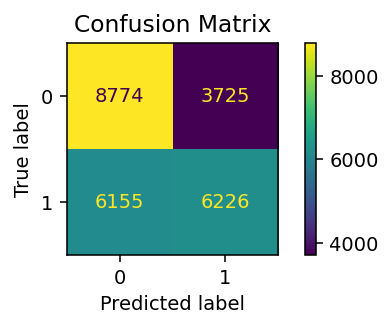

In [29]:
plot_confusion_matrix(svm, X_test, y_test)
plt.title('Confusion Matrix')
plt.show() 

#### SVM Lineal VALIDACIÓN- Con X_resampled2 , y_resampled2 <---- 2020-2 (balanceado)

              precision    recall  f1-score   support

           0       0.58      0.73      0.65     19597
           1       0.64      0.47      0.54     19597

    accuracy                           0.60     39194
   macro avg       0.61      0.60      0.59     39194
weighted avg       0.61      0.60      0.59     39194



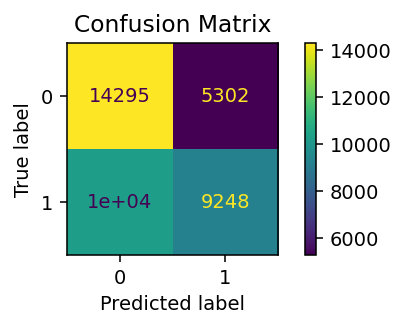

In [30]:
y_pred = svm.predict(X_resampled2)
print(classification_report(y_resampled2, y_pred))
plot_confusion_matrix(svm, X_resampled2, y_resampled2)
plt.title('Confusion Matrix')
plt.show() 

#### SVM Lineal - x2, dftest_y <---- 2020-2 (no balanceado)

              precision    recall  f1-score   support

           0       0.91      0.73      0.81    144573
           1       0.19      0.47      0.27     19597

    accuracy                           0.70    164170
   macro avg       0.55      0.60      0.54    164170
weighted avg       0.82      0.70      0.74    164170



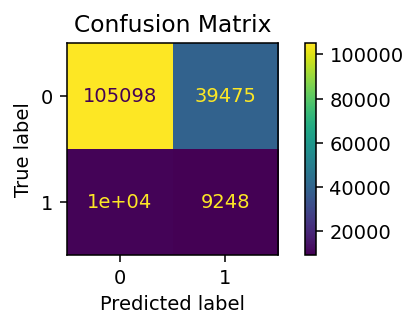

In [31]:
y_pred = svm.predict(x2)
report_dict=classification_report(dftest_y, y_pred, output_dict=True)
report_pd= pd.DataFrame(report_dict)
report_pd.to_latex()

In [32]:
# # defining parameter range
# param_grid = {#'C': [0.1, 10, 100, 1000], 
#               #'gamma': [1, 0.01, 0.0001],
#              'kernel': ['rbf','linear','poly', 'sigmoid']} 

# grid_svm = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# # fitting the model for grid search
# grid_svm.fit(X_train, y_train)
#grid_svm.best_params_

### SVM con rbf (Gausiano) (el otro tarda la mitad así que apaña más).

In [ ]:
# start = time.time()
# svmG = SVC(kernel='rbf')
# svmG.fit(X_train, y_train)

# y_pred = svmG.predict(X_test)
# print(classification_report(y_test, y_pred))
# end = time.time()
# print (" SVC RBF", end - start)

# plot_confusion_matrix(svmG, X_test, y_test)
# plt.title('Confusion Matrix')
# plt.show() 

### SVM Gaussian con BaggingClassifier - Usando train y test de periodo 2019-1 a 2020-1

In [16]:
n_estimators = 10
svmGB = BaggingClassifier(SVC(kernel='rbf', probability=True), max_samples=1.0 / n_estimators, n_estimators=n_estimators)
svmGB.fit(X_train, y_train)
y_pred = svmGB.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.77      0.66     12499
           1       0.66      0.45      0.54     12381

    accuracy                           0.61     24880
   macro avg       0.62      0.61      0.60     24880
weighted avg       0.62      0.61      0.60     24880



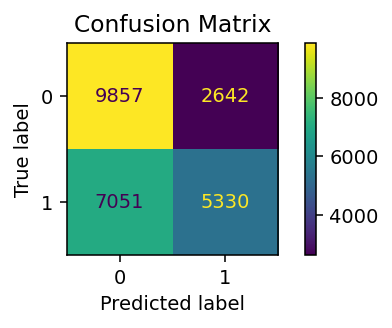

In [51]:
plot_confusion_matrix(svmGB, X_test, y_test)
plt.title('Confusion Matrix')
plt.show() 

#### SVM Gaussian con BaggingClassifier - Con X_resampled2 , y_resampled2 <---- 2020-2 (balanceado)

              precision    recall  f1-score   support

           0       0.58      0.76      0.66     19597
           1       0.65      0.45      0.53     19597

    accuracy                           0.61     39194
   macro avg       0.62      0.61      0.60     39194
weighted avg       0.62      0.61      0.60     39194



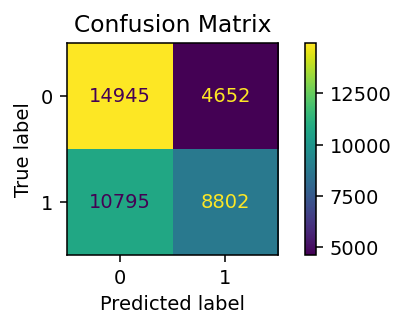

In [52]:
y_pred = svmGB.predict(X_resampled2)
print(classification_report(y_resampled2, y_pred))
plot_confusion_matrix(svmGB, X_resampled2, y_resampled2)
plt.title('Confusion Matrix')
plt.show() 

#### SVM Gaussian con BaggingClassifier - x2, dftest_y <---- 2020-2 (no balanceado)

In [18]:
y_pred = svmGB.predict(x2)
report_dict=classification_report(dftest_y, y_pred, output_dict=True)
report_pd= pd.DataFrame(report_dict)
report_pd.to_latex()


'\\begin{tabular}{lrrrrr}\n\\toprule\n{} &              0 &             1 &  accuracy &      macro avg &   weighted avg \\\\\n\\midrule\nprecision &       0.912109 &      0.196764 &  0.705275 &       0.554437 &       0.826719 \\\\\nrecall    &       0.736272 &      0.476604 &  0.705275 &       0.606438 &       0.705275 \\\\\nf1-score  &       0.814812 &      0.278536 &  0.705275 &       0.546674 &       0.750797 \\\\\nsupport   &  144573.000000 &  19597.000000 &  0.705275 &  164170.000000 &  164170.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'

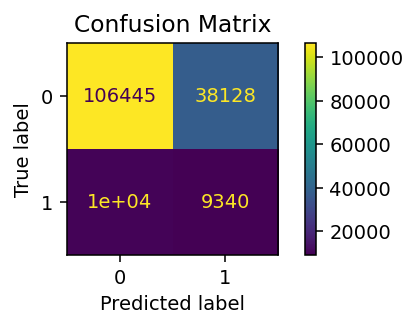

In [19]:
plot_confusion_matrix(svmGB, x2, dftest_y)
plt.title('Confusion Matrix')
plt.show() 

## Logit

In [20]:
logit = LogisticRegression(random_state=0, max_iter=100,tol=1e-07,C=10)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.69      0.64     12499
           1       0.62      0.51      0.56     12381

    accuracy                           0.60     24880
   macro avg       0.61      0.60      0.60     24880
weighted avg       0.61      0.60      0.60     24880



In [ ]:
disp = plot_confusion_matrix(logit, X_test, y_test,cmap='plasma')
disp.figure_.suptitle("Confusion Matrix", color="black")
plt.show()

In [35]:
# # defining parameter range
# param_grid = {'C': [0.1, 1, 10, 100, 1000, 10000],
#              'tol': [0.0000001,0.00000001,0.000000001, 0.0000000000001],
#              'max_iter':[100,500,1000,5000,10000]} 

# grid_logit = GridSearchCV(LogisticRegression(), param_grid, refit = True, verbose = 3)
  
# # fitting the model for grid search
# grid_logit.fit(X_train, y_train)
# grid_logit.best_params_

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END ....C=0.1, max_iter=100, tol=1e-07;, score=0.601 total time=   0.0s
[CV 2/5] END ....C=0.1, max_iter=100, tol=1e-07;, score=0.597 total time=   0.1s
[CV 3/5] END ....C=0.1, max_iter=100, tol=1e-07;, score=0.602 total time=   0.0s
[CV 4/5] END ....C=0.1, max_iter=100, tol=1e-07;, score=0.602 total time=   0.0s
[CV 5/5] END ....C=0.1, max_iter=100, tol=1e-07;, score=0.602 total time=   0.0s
[CV 1/5] END ....C=0.1, max_iter=100, tol=1e-08;, score=0.601 total time=   0.0s
[CV 2/5] END ....C=0.1, max_iter=100, tol=1e-08;, score=0.597 total time=   0.0s
[CV 3/5] END ....C=0.1, max_iter=100, tol=1e-08;, score=0.602 total time=   0.0s
[CV 4/5] END ....C=0.1, max_iter=100, tol=1e-08;, score=0.602 total time=   0.0s
[CV 5/5] END ....C=0.1, max_iter=100, tol=1e-08;, score=0.602 total time=   0.0s
[CV 1/5] END ....C=0.1, max_iter=100, tol=1e-09;, score=0.601 total time=   0.0s
[CV 2/5] END ....C=0.1, max_iter=100, tol=1e-0

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000],
                         'max_iter': [100, 500, 1000, 5000, 10000],
                         'tol': [1e-07, 1e-08, 1e-09, 1e-13]},
             verbose=3)

#### Logit - Con X_resampled2 , y_resampled2 <---- 2020-2 (balanceado)

              precision    recall  f1-score   support

           0       0.58      0.73      0.65     19597
           1       0.64      0.47      0.54     19597

    accuracy                           0.60     39194
   macro avg       0.61      0.60      0.60     39194
weighted avg       0.61      0.60      0.60     39194



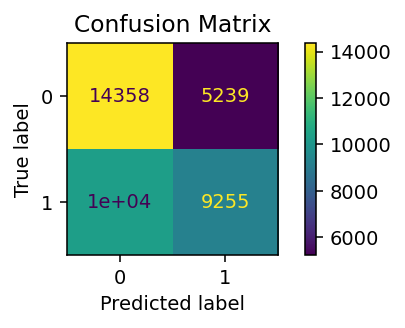

In [37]:
y_pred = logit.predict(X_resampled2)
print(classification_report(y_resampled2, y_pred))
plot_confusion_matrix(logit, X_resampled2, y_resampled2)
plt.title('Confusion Matrix')
plt.show() 

#### Logit - x2, dftest_y <---- 2020-2 (no balanceado)

In [22]:
y_pred = logit.predict(x2)
report_dict=classification_report(dftest_y, y_pred, output_dict=True)
report_pd= pd.DataFrame(report_dict)
report_pd.to_latex()


'\\begin{tabular}{lrrrrr}\n\\toprule\n{} &              0 &             1 &  accuracy &      macro avg &   weighted avg \\\\\n\\midrule\nprecision &       0.910767 &      0.191730 &  0.699348 &       0.551249 &       0.824936 \\\\\nrecall    &       0.730129 &      0.472266 &  0.699348 &       0.601198 &       0.699348 \\\\\nf1-score  &       0.810506 &      0.272735 &  0.699348 &       0.541620 &       0.746312 \\\\\nsupport   &  144573.000000 &  19597.000000 &  0.699348 &  164170.000000 &  164170.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Random Forest

In [39]:
# defining parameter range
param_grid = {'n_estimators': range(1, 16),
             'criterion': ['entropy','gini']} 

grid_rf = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END .criterion=entropy, n_estimators=1;, score=0.583 total time=   0.2s
[CV 2/5] END .criterion=entropy, n_estimators=1;, score=0.583 total time=   0.2s
[CV 3/5] END .criterion=entropy, n_estimators=1;, score=0.590 total time=   0.2s
[CV 4/5] END .criterion=entropy, n_estimators=1;, score=0.591 total time=   0.2s
[CV 5/5] END .criterion=entropy, n_estimators=1;, score=0.582 total time=   0.2s
[CV 1/5] END .criterion=entropy, n_estimators=2;, score=0.577 total time=   0.5s
[CV 2/5] END .criterion=entropy, n_estimators=2;, score=0.575 total time=   0.5s
[CV 3/5] END .criterion=entropy, n_estimators=2;, score=0.583 total time=   0.5s
[CV 4/5] END .criterion=entropy, n_estimators=2;, score=0.585 total time=   0.8s
[CV 5/5] END .criterion=entropy, n_estimators=2;, score=0.578 total time=   0.6s
[CV 1/5] END .criterion=entropy, n_estimators=3;, score=0.586 total time=   1.2s
[CV 2/5] END .criterion=entropy, n_estimators=3

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'n_estimators': range(1, 16)},
             verbose=3)

In [40]:
grid_rf.best_params_

{'criterion': 'entropy', 'n_estimators': 7}

Text(0, 0.5, 'Testing Accuracy')

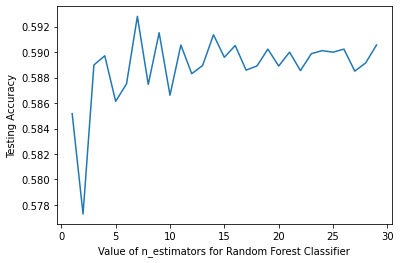

In [41]:
from sklearn.metrics import accuracy_score


scores =[]
for k in range(1, 30):
    rfc = RandomForestClassifier(n_estimators=k)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))


# %matplotlib inline

# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(range(1, 30), scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('Testing Accuracy')


### Ahora obtenemos el árbol óptimo:

In [61]:
# a = [0,1,3,4,5,6,7,8,9,10]
rf = RandomForestClassifier(
            n_estimators = 7,
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
             random_state = 123,
            criterion ='entropy'
         )
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))



# X_train[:,a].shape

              precision    recall  f1-score   support

           0       0.59      0.60      0.59     12499
           1       0.59      0.59      0.59     12381

    accuracy                           0.59     24880
   macro avg       0.59      0.59      0.59     24880
weighted avg       0.59      0.59      0.59     24880



(99518, 10)

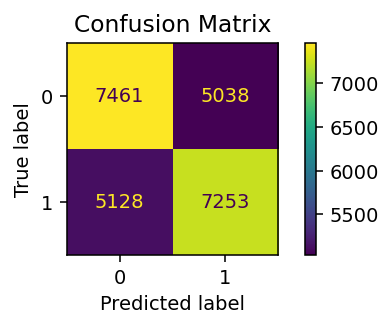

In [32]:
plot_confusion_matrix(rf, X_test, y_test)
plt.title('Confusion Matrix')
plt.show()

In [41]:
x1

,n_recl_com,n_recl_tec,log_total,n_recl_com_cumsum,n_recl_tec_cumsum,segmento_ggee,segmento_masivos,segmento_mmee,segmento_s/i,tipo_Fijo,tipo_Movil
0,0,0,10.023024,0,0,0,1,0,0,1,0
2,0,0,11.139354,0,0,0,1,0,0,0,1
3,0,0,10.865593,0,0,0,1,0,0,0,1
4,0,0,10.863629,0,0,0,1,0,0,0,1
6,0,0,11.203747,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
640172,0,0,11.864530,0,0,0,0,1,0,0,1
640173,0,0,11.388735,0,0,0,0,1,0,0,1
640176,0,0,10.828104,0,0,0,1,0,0,0,1
640177,0,0,10.827965,0,0,0,1,0,0,0,1


In [40]:
[x for x in range(len(importance))]



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Feature: 0, Score: 0.00671
Feature: 1, Score: 0.00667
Feature: 2, Score: 0.92325
Feature: 3, Score: 0.00864
Feature: 4, Score: 0.01156
Feature: 5, Score: 0.00878
Feature: 6, Score: 0.01097
Feature: 7, Score: 0.00420
Feature: 8, Score: 0.00486
Feature: 9, Score: 0.00566
Feature: 10, Score: 0.00869


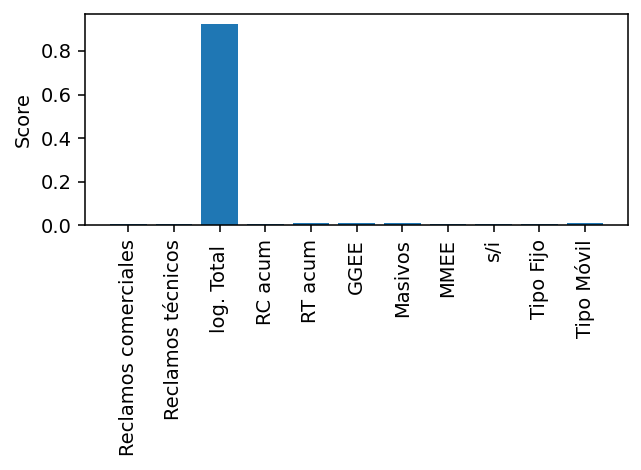

In [62]:
importance = rf.feature_importances_
x=["Reclamos comerciales", "Reclamos técnicos", "log. Total ", 
 "RC acum", "RT acum", "GGEE", "Masivos", "MMEE", "s/i", "Tipo Fijo", "Tipo Móvil"]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar(x, importance)
plt.xticks(rotation=90)
plt.ylabel('Score')
plt.show()

#### Random Forest - Con X_resampled2 , y_resampled2 <---- 2020-2 (balanceado)

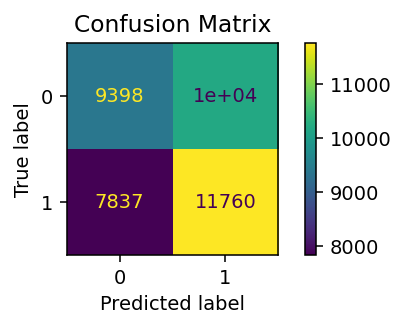

In [27]:

plot_confusion_matrix(rf, X_resampled2, y_resampled2)
plt.title('Confusion Matrix')
plt.show()

#### Random Forest - x2, dftest_y <---- 2020-2 (no balanceado)

In [26]:
y_pred = rf.predict(x2)
report_dict=classification_report(dftest_y, y_pred, output_dict=True)
report_pd= pd.DataFrame(report_dict)
report_pd.to_latex()
# plot_confusion_matrix(rf, x2, dftest_y)
# plt.title('Confusion Matrix')
# plt.show() 

'\\begin{tabular}{lrrrrr}\n\\toprule\n{} &              0 &             1 &  accuracy &      macro avg &   weighted avg \\\\\n\\midrule\nprecision &       0.898760 &      0.135546 &  0.495419 &       0.517153 &       0.807655 \\\\\nrecall    &       0.481231 &      0.600092 &  0.495419 &       0.540661 &       0.495419 \\\\\nf1-score  &       0.626832 &      0.221142 &  0.495419 &       0.423987 &       0.578405 \\\\\nsupport   &  144573.000000 &  19597.000000 &  0.495419 &  164170.000000 &  164170.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'